In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
# from tqdm import tqdm_notebook,trange
import numba
from numba import jit
from mpl_toolkits.mplot3d import Axes3D
from collections import Counter
from sklearn.decomposition import PCA
import math
from matplotlib.patches import Ellipse
from sklearn.cluster import SpectralClustering
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.cluster import DBSCAN
from sklearn.manifold import MDS
import seaborn as sns
import matplotlib
import scipy.stats as st
from sklearn.preprocessing import MinMaxScaler

In [2]:
store_path_base = r"/raid6/roozbeh/trip_similarity/"
data_path_base = r"../data/"
morning_df_parquet_name = r"koln_morning_dataframe.parquet"

In [3]:
if not os.path.isfile(os.path.join(data_path_base, morning_df_parquet_name)):
    store = pd.HDFStore(os.path.join(store_path_base,"kolntr.h5"))
    df = store['kolndf']
    store.close()
    halfday = df[df.time < 13 * 3600]
    morningdf = halfday.groupby('trip_id').apply(lambda tripdf : tripdf if (len(tripdf) >= 50) and (tripdf.time.min() > 6 * 3600 - 30) and (tripdf.time.max() < 10 * 3600 + 30) else None)
    morningdf_no_nan = morningdf[~morningdf.isna().any(axis=1)]
    print(morningdf.trip_id.value_counts(dropna=False))
    print(morningdf_no_nan.trip_id.value_counts(dropna=False))
    print("len(morningdf): {}, len(morningdf_no_nan): {}",len(morningdf),len(morningdf_no_nan))
    morningdf_no_nan.to_parquet('koln_morning_dataframe.parquet')
else:
    print("Morningdf parquet file found. Proceeding.")

Morningdf parquet file found. Proceeding.


In [ ]:
morningdf_no_nan = pd.read_parquet(os.path.join(data_path_base, morning_df_parquet_name))

In [ ]:
morningdf_no_nan

In [ ]:
xmax = morningdf_no_nan.x.max()
xmin = morningdf_no_nan.x.min()
ymax = morningdf_no_nan.y.max()
ymin = morningdf_no_nan.y.min()
tmax = morningdf_no_nan.time.max()
tmin = morningdf_no_nan.time.min()

In [ ]:
def min_max_scaler(series,min_,max_):
    return (series - min_)/(max_ - min_)

In [ ]:
morningdf_no_nan.x = min_max_scaler(morningdf_no_nan.x, xmin, xmax)
morningdf_no_nan.y = min_max_scaler(morningdf_no_nan.y, ymin, ymax)

In [ ]:
# morningdf_no_nan.sort_values(['trip_id','time'])

In [ ]:
def get_trips_50_points(tripdf):
    if len(tripdf) < 50:
        return
    
    tripdf = tripdf.sort_values(by='time').reset_index(drop=True)
    first_48_last = [tripdf.iloc[[0]], tripdf[1:-1].sample(n=48).sort_values(by='time'), tripdf.iloc[[-1]]]
    tripdf = pd.concat(first_48_last,axis=0).reset_index(drop=True)
    return tripdf.drop('trip_id',axis=1)
    

In [ ]:
tempdf = morningdf_no_nan.groupby('trip_id').apply(get_trips_50_points)


In [ ]:
tempdf

In [ ]:
tempdf = tempdf.reset_index(level=1)

In [ ]:
tempdf.rename({'level_1' : 'point_index'},inplace=True,axis=1)

In [ ]:
tempdf

In [ ]:
# tempdf['tupled'] = tempdf.apply(lambda x: (x.time,x.x,x.y,x.spd),axis=1)

In [ ]:
times_matrix = tempdf.pivot_table(index='trip_id',values='time',columns='point_index',aggfunc=lambda x: x)
x_matrix = tempdf.pivot_table(index='trip_id',values='x',columns='point_index',aggfunc=lambda x: x)
y_matrix = tempdf.pivot_table(index='trip_id',values='y',columns='point_index',aggfunc=lambda x: x)
spd_matrix = tempdf.pivot_table(index='trip_id',values='spd',columns='point_index',aggfunc=lambda x: x)

In [ ]:
times_matrix.columns =[str(i) for i in range(50)]
x_matrix.columns = [str(i) for i in range(50)]
y_matrix.columns = [str(i) for i in range(50)]
spd_matrix.columns = [str(i) for i in range(50)]

In [ ]:
times_matrix.to_parquet(os.path.join(data_path_base, 'morning_times_matrix.parquet'))
x_matrix.to_parquet(os.path.join(data_path_base, 'morning_x_matrix.parquet'))
y_matrix.to_parquet(os.path.join(data_path_base, 'morning_y_matrix.parquet'))
spd_matrix.to_parquet(os.path.join(data_path_base, 'morning_spd_matrix.parquet'))

In [ ]:
tempdf.to_parquet(os.path.join(data_path_base, 'morning_trips_df_with_50points.parquet'))

In [4]:
tempdf = pd.read_parquet(os.path.join(data_path_base, 'morning_trips_df_with_50points.parquet'))

## CHECKPOINT
The matrices created represent time, x, y, and speed at corresponding point (column) of the trip (row)

## PLOTTING CONFIG

In [367]:
mpl.rc('text', usetex=True)
# matplotlib.use('Agg')

In [368]:
mpl.rcParams['font.monospace'] = ['Computer Modern Typewriter','DejaVu Sans Mono','Bitstream Vera Sans Mono','Courier']

In [369]:
sns.set(style = 'darkgrid', context = 'paper', font_scale=3)
sns.set_palette("bright")
mpl.rcParams['font.family'] = ['monospace']

In [ ]:
# cyc_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
# matplotlib.rcParams.update({'font.size': 20,'xtick.labelsize':30,'ytick.labelsize':30})

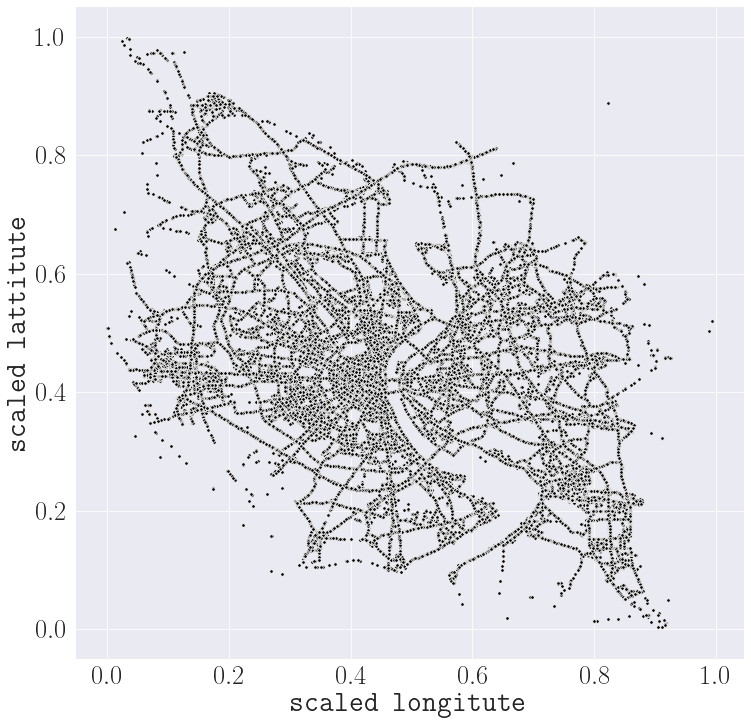

In [11]:
sampledf = tempdf.sample(200000)
plt.figure(figsize=(12,12))
sns.scatterplot(x = sampledf.x,y=sampledf.y, color='black', alpha=1, s=49, marker='.')
plt.ylabel('scaled lattitute')
plt.xlabel('scaled longitute')
del sampledf

------

#### Defining distance/similarity

In [30]:
w_x = 0.5
w_t = 1-w_x
#weighted geometric mean between time and space. arithmetic mean between origin and dest (/2).
@numba.jit(nopython=True)
def get_trip_similarity_wgm(t1,t2):
    odist = np.sqrt( (t1[1] - t2[1]) ** 2 + (t1[2] - t2[2])**2 )
    ddist = np.sqrt( (t1[5] - t2[5]) ** 2 + (t1[6] - t2[6])**2 )
    ot = np.absolute(t1[0]-t2[0])
    dt = np.absolute(t1[4]-t2[4])
    sim = np.exp(w_x * np.log(1./(1+odist)) + w_t * np.log(1./(1+ot)) )
    sim += np.exp(w_x * np.log(1./(1+ddist)) + w_t * np.log(1./(1+dt)) )
    return(sim/2)

##### Let's try getting an affinity matrix

In [33]:
def get_OD_from_50(tripdf):
    return pd.DataFrame([[tripdf.iloc[0,1], tripdf.iloc[0,2], tripdf.iloc[0,3], tripdf.iloc[0,4],
     tripdf.iloc[1,1], tripdf.iloc[1,2], tripdf.iloc[1,3], tripdf.iloc[1,4]]])
    
    

In [34]:
if not os.path.isfile(os.path.join(data_path_base,'morning_ODdf.parquet')):
    ODdf = tempdf.groupby('trip_id').apply(get_OD_from_50)
    ODdf.columns=['orig_time','orig_x','orig_y','orig_spd','dest_time','dest_x','dest_y','dest_spd']
    ODdf.reset_index(level=1,drop=True,inplace=True)
    ODdf.orig_time = min_max_scaler(ODdf.orig_time, tmin, tmax)
    ODdf.dest_time = min_max_scaler(ODdf.dest_time, tmin, tmax)
    ODdf.to_parquet(os.path.join(data_path_base, 'morning_ODdf.parquet'))
else:
    print("ODdf File found. Proceeding.")

ODdf File found. Proceeding.


In [35]:
ODdf = pd.read_parquet(os.path.join(data_path_base,'morning_ODdf.parquet'))

In [36]:
ODdf

,orig_time,orig_x,orig_y,orig_spd,dest_time,dest_x,dest_y,dest_spd
trip_id,,,,,,,,
1000007,26798.0,0.684278,0.570806,0.0,26804.0,0.685274,0.571578,9.74
1000011,23414.0,0.505815,0.250499,0.0,23417.0,0.505366,0.250347,6.08
1000015,23689.0,0.554151,0.161940,0.0,23734.0,0.554292,0.161518,10.15
1000020,26928.0,0.389398,0.389645,0.0,26935.0,0.390773,0.390996,13.07
1000024,25380.0,0.420249,0.567624,0.0,25396.0,0.421578,0.562920,8.20
...,...,...,...,...,...,...,...,...
73013,29902.0,0.804917,0.152156,0.0,29903.0,0.804919,0.152085,2.20
732987,35788.0,0.368885,0.342547,0.0,35792.0,0.369623,0.342151,8.16
734746,27918.0,0.353437,0.634457,0.0,27926.0,0.355882,0.634051,12.66


In [13]:
# sampleODdf = ODdf.sample(frac=0.02) #oops forgot random state!
# sampleODdf.to_parquet(os.path.join(data_path_base, 'morning_sampleODdf.parquet'))
sampleODdf = pd.read_parquet(os.path.join(data_path_base, 'morning_sampleODdf.parquet'))

In [16]:
# ODdf.columns = ['orig time','orig x','orig y','orig spd','dest time','dest x','dest y','dest spd']
sampleODdf.columns = ['orig time','orig x','orig y','orig spd','dest time','dest x','dest y','dest spd']

In [17]:
sampleODdf

,orig time,orig x,orig y,orig spd,dest time,dest x,dest y,dest spd
trip_id,,,,,,,,
101976,0.916033,0.248212,0.522616,0.0,0.917139,0.252364,0.519405,7.77
1249482,0.494467,0.678979,0.180198,0.0,0.494743,0.679671,0.179861,7.52
1064676,0.248651,0.376208,0.414576,0.0,0.249620,0.379531,0.413418,7.08
1393720,0.305436,0.400191,0.500733,0.0,0.306474,0.392289,0.500255,13.36
1263272,0.404620,0.345205,0.357355,0.0,0.404897,0.344637,0.357794,8.12
...,...,...,...,...,...,...,...,...
1067705,0.651542,0.402945,0.404750,0.0,0.651681,0.403204,0.404770,3.93
258989,0.373911,0.702427,0.388029,0.0,0.374187,0.701619,0.388220,8.32
1485451,0.632937,0.365770,0.470154,0.0,0.633006,0.365818,0.470127,1.47


In [31]:
sim_matrix = pairwise_distances(sampleODdf,metric=get_trip_similarity_wgm,n_jobs=1)
# sim_matrix = pd.read_parquet(os.path.join(data_path_base, 'sim_matrix_scaled_frac0.02.parquet'))

In [32]:
sim_matrix.shape

(3492, 3492)

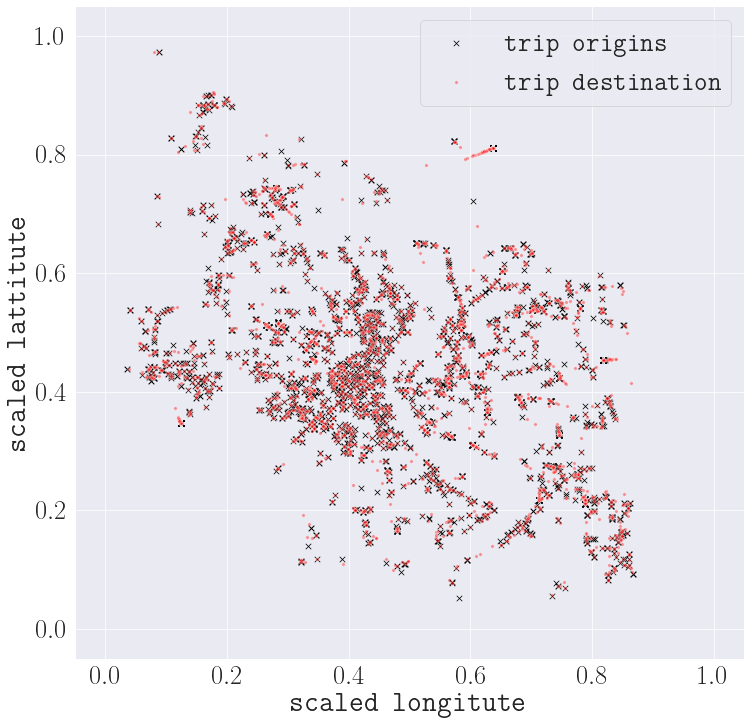

In [23]:
plt.figure(figsize=(12,12))
sns.scatterplot(x = sampleODdf['orig x'],y=sampleODdf['orig y'], color='black', alpha=1, marker='x', s=30, label='trip origins')
sns.scatterplot(x = sampleODdf['dest x'],y=sampleODdf['dest y'], color='red', alpha=0.4, s=12, label='trip destination')
plt.ylim((-0.05,1.05))
plt.xlim((-0.05,1.05))
plt.ylabel('scaled lattitute')
plt.xlabel('scaled longitute');

-----

-------

### Attempting clustering

In [146]:
sim_matrix_lkern = np.exp(-1 * sim_matrix  )

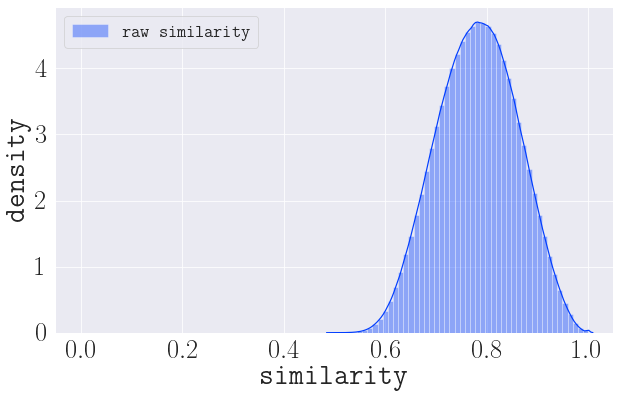

In [148]:
plt.figure(figsize=(10,6))
ax =  sns.distplot(np.reshape(sim_matrix,-1),norm_hist=False,label="raw similarity")
# ax =  sns.distplot(np.reshape(sim_matrix_lkern,-1),norm_hist=True,ax=ax,label="laplacian kernel")
ax.set_xlabel("similarity")
ax.set_xlim((-0.05,1.05))
ax.set_ylabel("density")
plt.legend(prop= {"size" : 18})
plt.show()

In [34]:
xyt_columns = ['orig time','orig x','orig y','dest time','dest x','dest y']

In [35]:
pca_obj = PCA(n_components=3)

In [36]:
pca_obj.fit(sampleODdf[xyt_columns])

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [37]:
np.cumsum(pca_obj.explained_variance_ratio_)

array([0.50141665, 0.8539283 , 0.99988399])

In [383]:
n_clusters = 5

In [384]:
spc_obj = SpectralClustering(n_clusters = n_clusters, affinity='precomputed',n_jobs=-1,assign_labels="discretize",random_state=54321)

In [385]:
spc_obj.fit(sim_matrix)

SpectralClustering(affinity='precomputed', assign_labels='discretize', coef0=1,
                   degree=3, eigen_solver=None, eigen_tol=0.0, gamma=1.0,
                   kernel_params=None, n_clusters=5, n_components=None,
                   n_init=10, n_jobs=-1, n_neighbors=10, random_state=54321)

In [386]:
Counter(spc_obj.labels_)

Counter({3: 735, 4: 614, 1: 764, 0: 512, 2: 867})

In [387]:
pca_projection = pca_obj.transform(sampleODdf[xyt_columns])

In [388]:
# cmap = plt.cm.get_cmap('jet', 24)

In [389]:
# mpl.colors.to_hex(cmap(5))

In [390]:
# mpl.rcParams['font.family'] = 'sans-serif'

Per below cell, first component is more focused on longitute while the second component is a combination of latitute and time (for both origin and destination points).

In [391]:
pca_obj.components_

array([[ 0.70598704, -0.04055922,  0.01410157,  0.70562792, -0.04047173,
         0.0137723 ],
       [-0.04182329, -0.61474127,  0.34689272, -0.04246323, -0.61526079,
         0.34591973],
       [ 0.00751077,  0.34751905,  0.6181706 ,  0.00794205,  0.34568158,
         0.61439432]])

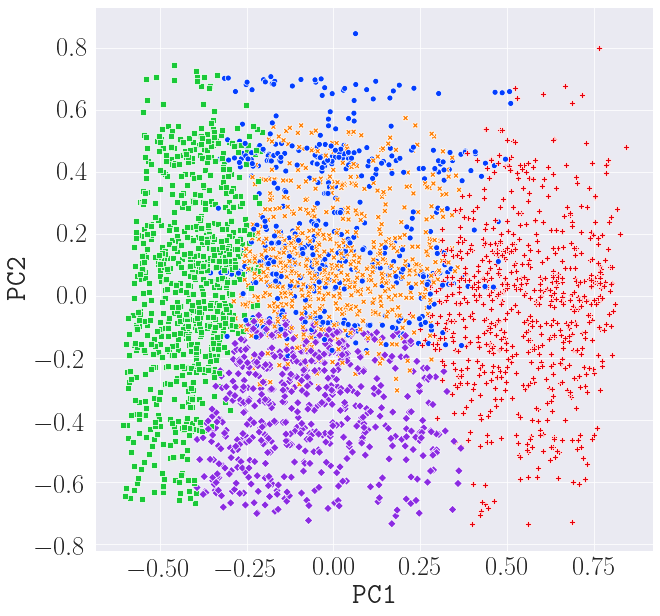

In [392]:
plt.figure(figsize=(10,10))
sns.scatterplot(pca_projection[:,0],
                pca_projection[:,1],
                s=36,
                alpha=1,
                hue_order=range(n_clusters),
                hue=spc_obj.labels_,
                style=spc_obj.labels_,
                style_order = range(n_clusters),
                legend=False,
                palette=sns.color_palette('bright')[:n_clusters])
ax = plt.gca()
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
plt.show()

In [393]:
from sklearn.manifold import spectral_embedding

In [395]:
spc_embedding = spectral_embedding(sim_matrix,n_components=2)

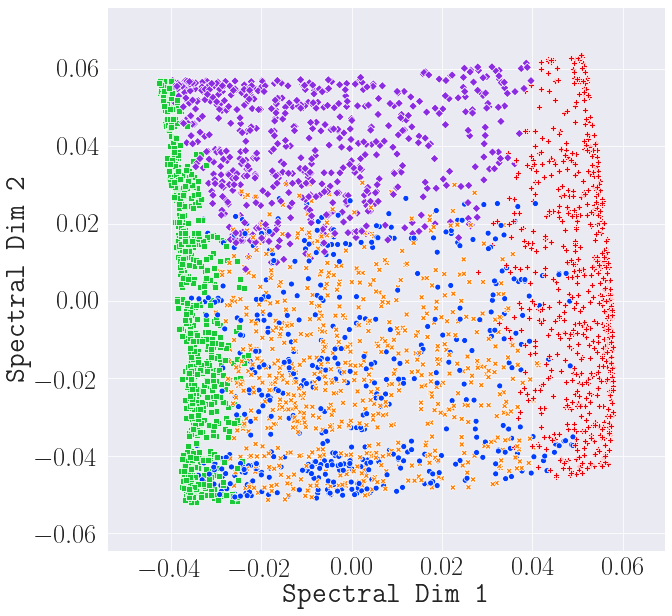

In [396]:
plt.figure(figsize=(10,10))
ax = sns.scatterplot(spc_embedding[:,0]*100,spc_embedding[:,1]*100,
                     s=36,
                     alpha=1,
                     hue=spc_obj.labels_,
                     hue_order=range(n_clusters),
                     style=spc_obj.labels_,
                     style_order = range(n_clusters),
                     legend=False,
                     palette=sns.color_palette('bright')[:n_clusters]
                    )
ax.set_xlabel("Spectral Dim 1")
ax.set_ylabel("Spectral Dim 2")#,fontsize=24)
# ax.legend(loc='upper right', bbox_to_anchor=(1.01, 1.01), ncol=1,borderpad=0.2)
plt.show()

In [235]:
#For adjusting aesthetics of legend:
# borderpad          the fractional whitespace inside the legend border
# labelspacing       the vertical space between the legend entries
# handlelength       the length of the legend handles
# handletextpad      the pad between the legend handle and text
# borderaxespad      the pad between the axes and legend border
# columnspacing      the spacing between columns

In [237]:
from scipy.sparse import csgraph
from numpy import linalg as LA
L = csgraph.laplacian(sim_matrix, normed=True)
eigenvalues, eigenvectors = LA.eig(L)

Text(0, 0.5, 'Eigenvalues')

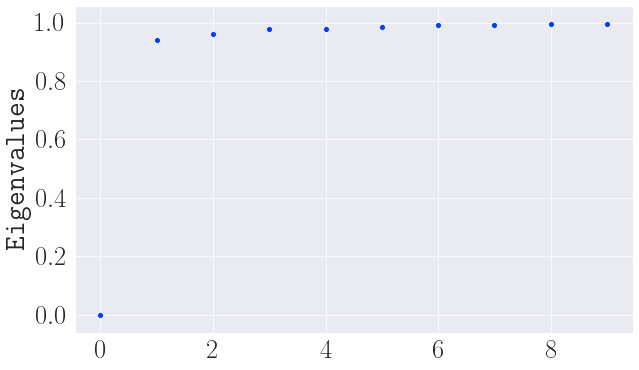

In [238]:
plt.figure(figsize=(10,6))
sns.scatterplot(y=eigenvalues[:10],x=range(10),s=36)
plt.ylabel('Eigenvalues')# of Normalized Laplacian')

In [239]:
eigenvalues

array([-5.84951831e-17,  9.39017168e-01,  9.60534754e-01, ...,
        1.00035409e+00,  1.00035410e+00,  1.00035410e+00])

In [240]:
index_largest_gap = np.argsort(np.diff(eigenvalues))[::-1][:5]

In [241]:
index_largest_gap + 1

array([1, 2, 3, 5, 6], dtype=int64)

<IPython.core.display.Javascript object>


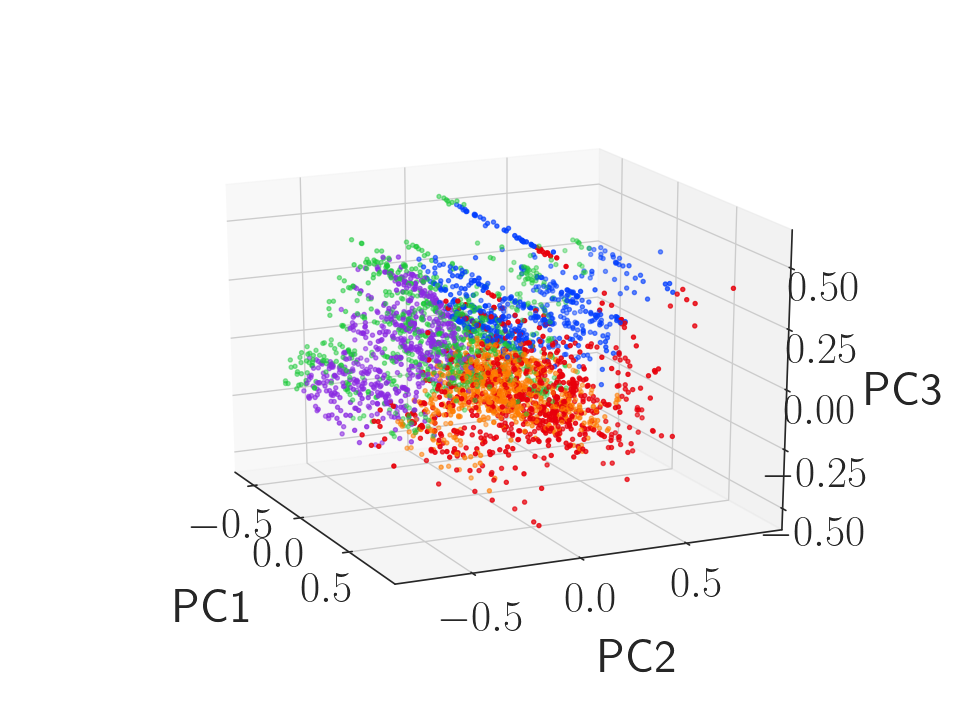

In [359]:
%matplotlib notebook
sns.set_style('white')
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_projection[:,0],pca_projection[:,1],pca_projection[:,2],
           s=6,
           c=[sns.color_palette('bright')[i] for i in spc_obj.labels_],)
ax.set_xlabel('PC1')
ax.xaxis.labelpad = 30
ax.set_ylabel('PC2')
ax.yaxis.labelpad = 30
ax.set_zlabel('PC3')
ax.zaxis.labelpad = 20
plt.show()

In [360]:
%matplotlib inline

-----

----

Plot every point?

In [ ]:
# pca_projection_all = pca_obj.transform(OD)

In [ ]:
# plt.figure(figsize=(28,18))
# plt.scatter(pca_projection_all[:,0],pca_projection_all[:,1],s=0.1)
# plt.show()

------

Let's try a simple euclidean distance in R^6

In [292]:
eucl_dist = pairwise_distances(sampleODdf[xyt_columns],metric='euclidean')

In [245]:
euc_sim = 1/(1+eucl_dist)

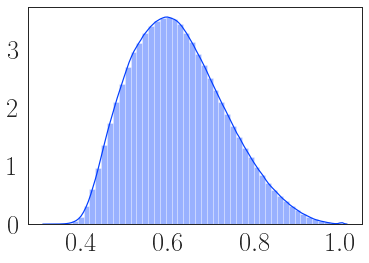

In [246]:
ax =  sns.distplot(np.reshape(euc_sim,-1),norm_hist=False,label="raw similarity")

In [362]:
spc_obj_eucl = SpectralClustering(n_clusters=n_clusters,affinity='rbf')

In [363]:
spc_obj_eucl.fit(sampleODdf[xyt_columns])

SpectralClustering(affinity='rbf', assign_labels='kmeans', coef0=1, degree=3,
                   eigen_solver=None, eigen_tol=0.0, gamma=1.0,
                   kernel_params=None, n_clusters=5, n_components=None,
                   n_init=10, n_jobs=None, n_neighbors=10, random_state=None)

In [364]:
Counter(spc_obj_eucl.labels_)

Counter({4: 502, 1: 412, 2: 1169, 0: 915, 3: 494})

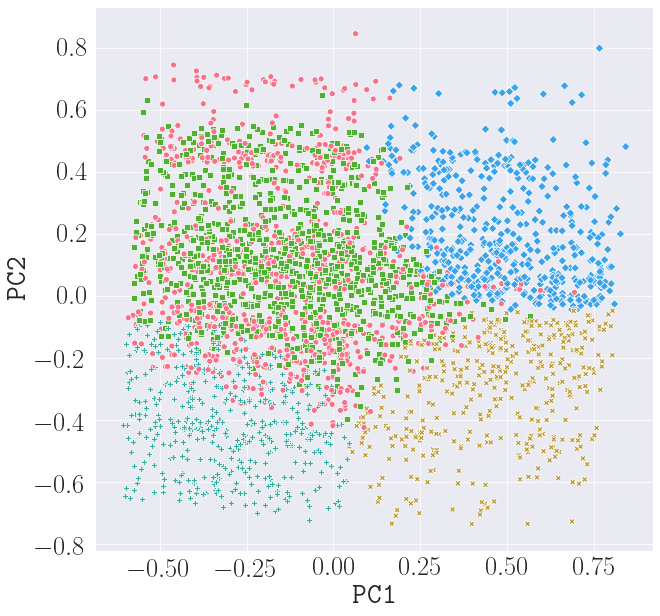

In [370]:
plt.figure(figsize=(10,10))
sns.scatterplot(pca_projection[:,0],
                pca_projection[:,1],
                s=36,
                alpha=1,
                hue_order=range(n_clusters),
                hue=spc_obj_eucl.labels_,
                style=spc_obj_eucl.labels_,
                style_order = range(n_clusters),
                legend=False,
                palette=sns.color_palette('husl')[:n_clusters])
ax = plt.gca()
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
plt.show()

In [371]:
spc_eucl_embedding = spectral_embedding(np.exp(-2 * eucl_dist ** 2),n_components=2)

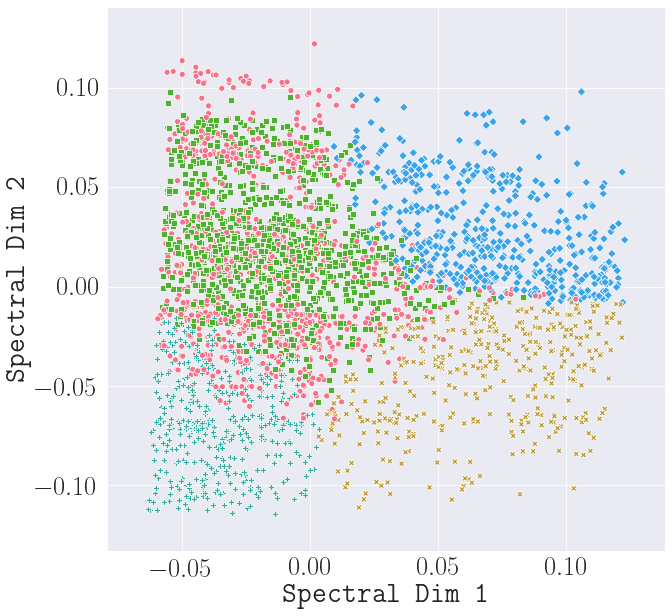

In [372]:
plt.figure(figsize=(10,10))
ax = sns.scatterplot(spc_eucl_embedding[:,0]*100,spc_eucl_embedding[:,1]*100,
                     s=36,
                     alpha=1,
                     hue=spc_obj_eucl.labels_,
                     hue_order=range(n_clusters),
                     style=spc_obj_eucl.labels_,
                     style_order = range(n_clusters),
                     legend=False,
                     palette=sns.color_palette('husl')[:n_clusters]
                    )
ax.set_xlabel("Spectral Dim 1")
ax.set_ylabel("Spectral Dim 2")#,fontsize=24)
# ax.legend(loc='upper right', bbox_to_anchor=(1.01, 1.01), ncol=1,borderpad=0.2)
plt.show()

In [373]:
def get_ellipse(cluster,clr):
    data_x = cluster['orig x'].append(cluster['dest x'])
    data_y = cluster['orig y'].append(cluster['dest y'])

    avg_x = np.mean(data_x)
    avg_y = np.mean(data_y)
    x_diff = data_x - avg_x
    y_diff = data_y - avg_y
    x_diff_sq = [i**2 for i in x_diff]
    slope = sum(x*y for x,y in zip(x_diff,y_diff)) / sum(x_diff_sq)
    return(Ellipse((avg_x,avg_y),3*data_x.std(),3*data_y.std(),math.degrees(math.atan(slope)),facecolor='none',lw=1,edgecolor=clr))

In [374]:
def get_ellipses_figure(ODdf, cluster_labels, color_palette=None):
    n_cluster = len(set(cluster_labels))
#     colors = [mpl.colors.to_hex(cmap(i/n_cluster)) for i in range(n_cluster)]
    if not color_palette:
        colors = sns.color_palette("bright", n_cluster)
    else:
        colors = color_palette
    plt.figure(figsize=(10,10))
    ax = plt.subplot(111,aspect='equal')
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    for i in range(n_cluster):
        cluster = ODdf[cluster_labels == i]
        sample_cluster = cluster.sample(100)
        sns.scatterplot(x = sample_cluster['orig x'],y=sample_cluster['orig y'], color=[colors[i]], alpha=1, marker='x', s=30, label='trip origins')
        sns.scatterplot(x = sample_cluster['dest x'],y=sample_cluster['dest y'], color=[colors[i]], alpha=0.4, s=12, label='trip destination')
#         ax.scatter(np.mean(cluster['orig x']),np.mean(cluster['orig y']),c=[colors[i]])
#         ax.scatter(np.mean(cluster['dest x']),np.mean(cluster['dest y']),c=[colors[i]],marker='s')
        ax.add_artist(get_ellipse(cluster,colors[i]))
    ax.set_xlabel("Scaled longitute",fontsize=22)
    ax.set_ylabel("Scaled latitude",fontsize=22)
    ax.get_legend().remove()
    return ax

In [253]:
# sns.set(style = 'darkgrid', context = 'paper', font_scale=3)
# sns.set_palette("bright")
# mpl.rcParams['font.family'] = ['monospace']

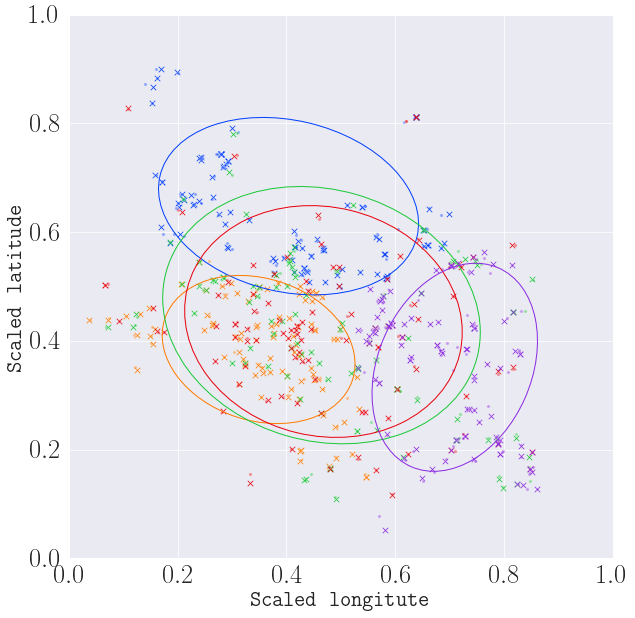

In [375]:
get_ellipses_figure(sampleODdf, spc_obj.labels_)

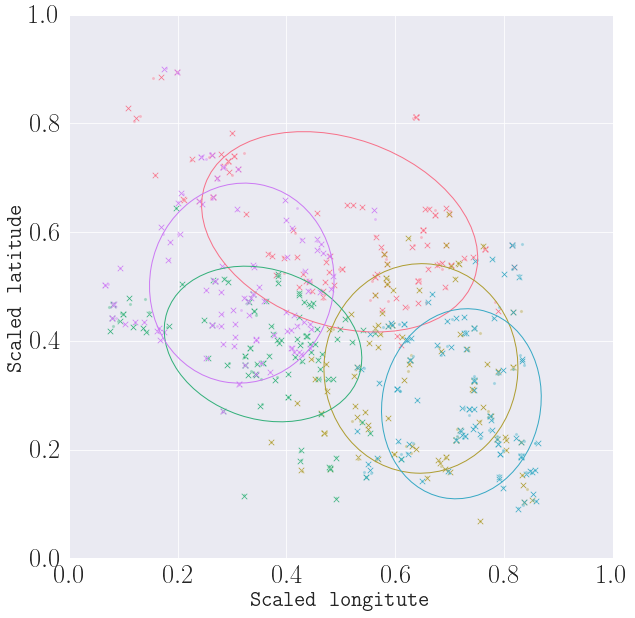

In [376]:
get_ellipses_figure(sampleODdf, spc_obj_eucl.labels_, sns.color_palette("husl", n_clusters))

In [259]:
# ODdf.columns = ['orig time','orig x','orig y','orig spd','dest time','dest x','dest y','dest spd']
# sampleODdf.columns = ['orig time','orig x','orig y','orig spd','dest time','dest x','dest y','dest spd']

In [377]:
def get_kdes_for_times(ODdf, cluster_labels, colors = None):
    n_cluster = len(set(cluster_labels))
    fig = plt.figure(figsize=(14,10))

    g = sns.JointGrid(x=ODdf['orig time'],y=ODdf['dest time'], height =10)
    if colors is None:
        colors = sns.color_palette("bright", n_cluster)
#     colors = ['blue','red','purple','green']
#     colors = ['#a6cee3', '#1f78b4', '#b2df8a', '#33a02c']
    for i in range(n_cluster):
        cluster = ODdf[cluster_labels == i]
        sns.kdeplot(cluster['orig time'],cluster['dest time'],
                          shade=True,
                          shade_lowest=False,
                          legend=True,
                          color=colors[i],
                          ax=g.ax_joint)        
#         print(len(g.ax_joint.collections))
        sns.distplot(cluster['orig time'], kde=False, color=colors[i], ax=g.ax_marg_x, label='orig time')
        sns.distplot(cluster['dest time'], kde=False, color=colors[i], ax=g.ax_marg_y, vertical=True, label='dest time')
    for coll in g.ax_joint.collections:
        if coll.get_alpha() is None:
            coll.set_alpha(0.5)
#     g.ax_joint.collections[0].set_alpha(0)
#     g.ax_joint.collections[10].set_alpha(0)
#     g.ax_joint.collections[19].set_alpha(0)
#     g.ax_joint.collections[29].set_alpha(0)
    g.ax_marg_x.set_xlabel('')
    g.ax_marg_y.set_ylabel('')
    return g


<Figure size 1008x720 with 0 Axes>

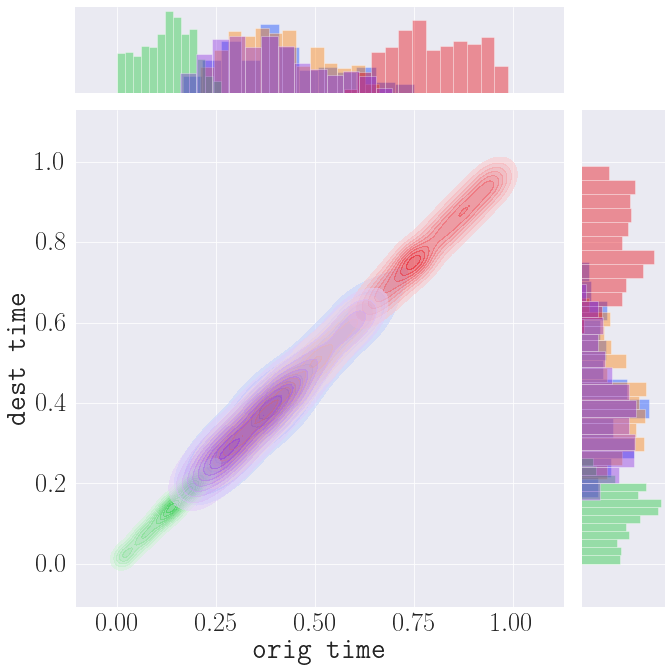

In [378]:
# sns.set_context('paper',font_scale=3)
get_kdes_for_times(sampleODdf, spc_obj.labels_)
plt.show()

<Figure size 1008x720 with 0 Axes>

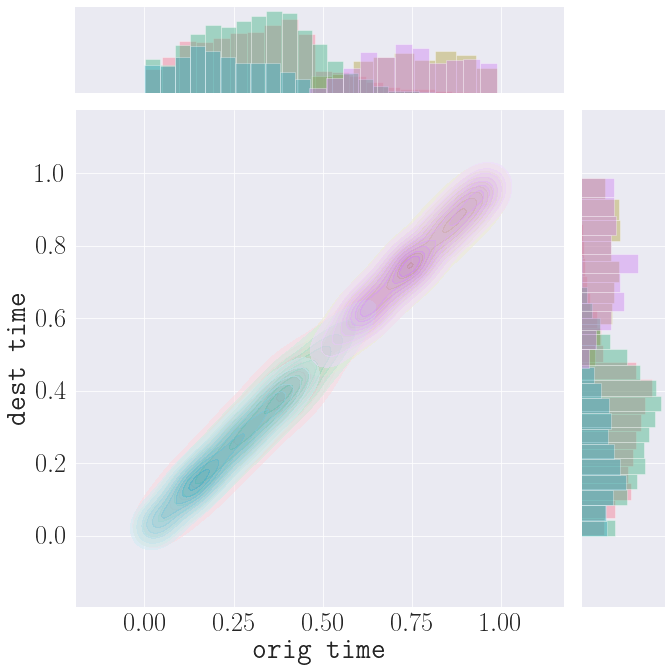

In [379]:
get_kdes_for_times(sampleODdf, spc_obj_eucl.labels_, colors=sns.color_palette("husl", n_clusters))
plt.show()

Let's define some sort of label for trips so that we can measure against!

In [263]:
sampleODdf['orig x grid'] = (sampleODdf['orig x']*10).astype(np.int)
sampleODdf['orig y grid'] = (sampleODdf['orig y']*10).astype(np.int)
sampleODdf['dest x grid'] = (sampleODdf['dest x']*10).astype(np.int)
sampleODdf['dest y grid'] = (sampleODdf['dest y']*10).astype(np.int)
sampleODdf['orig time slot'] = (sampleODdf['orig time']*8).astype(np.int)
sampleODdf['dest time slot'] = (sampleODdf['dest time']*8).astype(np.int)
sampleODdf['orig grid id'] = sampleODdf['orig x grid'] * 10 + sampleODdf['orig y grid']
sampleODdf['dest grid id'] = sampleODdf['dest x grid'] * 10 + sampleODdf['dest y grid']
sampleODdf['wgm label'] = spc_obj.labels_
sampleODdf['eucl label'] = spc_obj_eucl.labels_

In [264]:
sampleODdf

,orig time,orig x,orig y,orig spd,dest time,dest x,dest y,dest spd,orig x grid,orig y grid,dest x grid,dest y grid,orig time slot,dest time slot,orig grid id,dest grid id,wgm label,eucl label
trip_id,,,,,,,,,,,,,,,,,,
101976,0.916033,0.248212,0.522616,0.0,0.917139,0.252364,0.519405,7.77,2,5,2,5,7,7,25,25,1,2
1249482,0.494467,0.678979,0.180198,0.0,0.494743,0.679671,0.179861,7.52,6,1,6,1,3,3,61,61,3,3
1064676,0.248651,0.376208,0.414576,0.0,0.249620,0.379531,0.413418,7.08,3,4,3,4,1,1,34,34,0,0
1393720,0.305436,0.400191,0.500733,0.0,0.306474,0.392289,0.500255,13.36,4,5,3,5,2,2,45,35,0,0
1263272,0.404620,0.345205,0.357355,0.0,0.404897,0.344637,0.357794,8.12,3,3,3,3,3,3,33,33,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1067705,0.651542,0.402945,0.404750,0.0,0.651681,0.403204,0.404770,3.93,4,4,4,4,5,5,44,44,1,2
258989,0.373911,0.702427,0.388029,0.0,0.374187,0.701619,0.388220,8.32,7,3,7,3,2,2,73,73,3,3
1485451,0.632937,0.365770,0.470154,0.0,0.633006,0.365818,0.470127,1.47,3,4,3,4,5,5,34,34,1,2


In [265]:
#group can be either grid orig dest pair or time orig dest pair (with a label column as well)
def label_coverage_per_group(group_label_df, label_column = 'wgm label'):
    most_common_label = Counter(group_label_df[label_column]).most_common(1)[0]
    return most_common_label[1]/len(group_label_df)

In [266]:
wgm_most_common_ratios_per_grid = sampleODdf.groupby(['orig grid id','dest grid id']).apply(label_coverage_per_group)

In [267]:
eucl_most_common_ratios_per_grid = sampleODdf.groupby(['orig grid id','dest grid id']).apply(lambda x: label_coverage_per_group(x,'eucl label'))

In [268]:
np.mean(eucl_most_common_ratios_per_grid),np.std(eucl_most_common_ratios_per_grid)

(0.868230019599998, 0.17225188166551395)

In [269]:
np.mean(wgm_most_common_ratios_per_grid), np.std(wgm_most_common_ratios_per_grid)

(0.7263299272531402, 0.24455853025211105)

In [270]:
wgm_most_common_ratios_per_time = sampleODdf.groupby(['orig time slot','dest time slot']).apply(label_coverage_per_group)

In [271]:
eucl_most_common_ratios_per_time = sampleODdf.groupby(['orig time slot','dest time slot']).apply(lambda x: label_coverage_per_group(x,'eucl label'))

In [272]:
np.mean(wgm_most_common_ratios_per_time),np.std(wgm_most_common_ratios_per_time)

(0.7836252931782453, 0.21532724192104735)

In [273]:
np.mean(eucl_most_common_ratios_per_time),np.std(eucl_most_common_ratios_per_time)

(0.6247488230385566, 0.25847682223193713)

In [349]:
np.random.seed(54321)
confusion_per_n_cluster = []
for n_clusters in [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]:
    confusion_per_repeat = []
    for repeat in range(3):
        spc_obj = SpectralClustering(n_clusters = n_clusters, affinity='precomputed',n_jobs=1,assign_labels="kmeans")
        spc_obj_eucl = SpectralClustering(n_clusters=n_clusters,affinity='rbf')
        spc_obj.fit(sim_matrix)
        spc_obj_eucl.fit(sampleODdf[xyt_columns])
        sampleODdf['wgm label'] = spc_obj.labels_
        sampleODdf['eucl label'] = spc_obj_eucl.labels_
        wgm_most_common_ratios_per_grid = sampleODdf.groupby(['orig grid id','dest grid id'])\
                                                    .apply(label_coverage_per_group)
        eucl_most_common_ratios_per_grid = sampleODdf.groupby(['orig grid id','dest grid id'])\
                                                     .apply(lambda x: label_coverage_per_group(x,'eucl label'))
        wgm_most_common_ratios_per_time = sampleODdf.groupby(['orig time slot','dest time slot'])\
                                                    .apply(label_coverage_per_group)
        eucl_most_common_ratios_per_time = sampleODdf.groupby(['orig time slot','dest time slot'])\
                                                     .apply(lambda x: label_coverage_per_group(x,'eucl label'))
        
        confusion_per_repeat.append([np.mean(wgm_most_common_ratios_per_grid),np.mean(eucl_most_common_ratios_per_grid),
                                     np.mean(wgm_most_common_ratios_per_time),np.mean(eucl_most_common_ratios_per_time),
                                     np.std(wgm_most_common_ratios_per_grid),np.std(eucl_most_common_ratios_per_grid),
                                     np.std(wgm_most_common_ratios_per_time),np.std(eucl_most_common_ratios_per_time)])
    confusion_per_n_cluster.append(np.mean(confusion_per_repeat,axis=0))
    print('n_cluster {} done'.format(n_clusters))

n_cluster 2 done
n_cluster 3 done
n_cluster 4 done
n_cluster 5 done
n_cluster 6 done
n_cluster 7 done
n_cluster 8 done
n_cluster 9 done
n_cluster 10 done
n_cluster 11 done
n_cluster 12 done
n_cluster 13 done
n_cluster 14 done
n_cluster 15 done
n_cluster 16 done


In [350]:
np.array(confusion_per_n_cluster)

array([[0.81616155, 0.83453237, 0.98637138, 0.98979592, 0.19079767,
        0.17858006, 0.04913869, 0.03679134],
       [0.84072226, 0.85680354, 0.74955569, 0.73030952, 0.18347285,
        0.17764356, 0.20244689, 0.20353822],
       [0.7290286 , 0.87362062, 0.78570176, 0.62529841, 0.24235022,
        0.16785809, 0.20703086, 0.25739241],
       [0.73179536, 0.82713927, 0.72165234, 0.5717171 , 0.24442878,
        0.19285381, 0.209742  , 0.21553656],
       [0.82664138, 0.76962549, 0.65424809, 0.60411   , 0.23139332,
        0.23551491, 0.2233084 , 0.20631331],
       [0.7781887 , 0.81283026, 0.71605779, 0.60943122, 0.26379046,
        0.21412947, 0.25431926, 0.20780533],
       [0.80397541, 0.76381679, 0.65455827, 0.63982701, 0.26178434,
        0.2326377 , 0.22782904, 0.23913672],
       [0.7803647 , 0.79913606, 0.66022461, 0.61490521, 0.27758028,
        0.2154615 , 0.21656155, 0.20660992],
       [0.80800234, 0.77431977, 0.60012148, 0.62377359, 0.26161011,
        0.22812735, 0.234017

In [381]:
for row in confusion_per_n_cluster:
    print('{:.2f}+-{:.2f}  {:.2f}-+{:.2f}  {:.2f}+-{:.2f}  {:.2f}+-{:.2f}'.format(row[0],row[4],row[1],row[5],row[2],row[6],row[3],row[7]))

0.82+-0.19  0.83-+0.18  0.99+-0.05  0.99+-0.04
0.84+-0.18  0.86-+0.18  0.75+-0.20  0.73+-0.20
0.73+-0.24  0.87-+0.17  0.79+-0.21  0.63+-0.26
0.73+-0.24  0.83-+0.19  0.72+-0.21  0.57+-0.22
0.83+-0.23  0.77-+0.24  0.65+-0.22  0.60+-0.21
0.78+-0.26  0.81-+0.21  0.72+-0.25  0.61+-0.21
0.80+-0.26  0.76-+0.23  0.65+-0.23  0.64+-0.24
0.78+-0.28  0.80-+0.22  0.66+-0.22  0.61+-0.21
0.81+-0.26  0.77-+0.23  0.60+-0.23  0.62+-0.20
0.84+-0.24  0.79-+0.23  0.54+-0.26  0.63+-0.22
0.80+-0.26  0.78-+0.23  0.59+-0.29  0.60+-0.20
0.83+-0.25  0.76-+0.24  0.53+-0.28  0.62+-0.18
0.78+-0.29  0.78-+0.24  0.60+-0.23  0.57+-0.20
0.80+-0.27  0.77-+0.24  0.54+-0.26  0.57+-0.21
0.78+-0.28  0.76-+0.24  0.55+-0.24  0.57+-0.21


In [339]:
pd.DataFrame(np.array(confusion_per_n_cluster))#,columns=['wgm grid coverage','eucl grid coverage',])

,0,1,2,3,4,5,6,7
0,0.801312,0.834532,0.973311,0.989796,0.197369,0.178580,0.096230,0.036791
1,0.844433,0.856804,0.746276,0.730383,0.181632,0.177644,0.204454,0.203468
2,0.727325,0.872366,0.783778,0.619540,0.244047,0.170147,0.214806,0.258588
3,0.747249,0.827506,0.716967,0.571656,0.239317,0.192855,0.239059,0.216053
4,0.828962,0.770254,0.648681,0.603788,0.230118,0.234941,0.232551,0.206113
5,0.779080,0.812585,0.694172,0.610951,0.263844,0.214377,0.252973,0.207358
6,0.809744,0.761498,0.636214,0.641824,0.255654,0.233569,0.246154,0.239205
7,0.779268,0.799309,0.653190,0.616453,0.272528,0.216071,0.224300,0.203597
8,0.798157,0.773433,0.590750,0.624430,0.256185,0.228971,0.249134,0.203682
9,0.838345,0.793810,0.548378,0.631049,0.238404,0.225561,0.260830,0.216367
